# Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST
테스트 데이터로 제공

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
28*28

784

Saving figure some_digit_plot


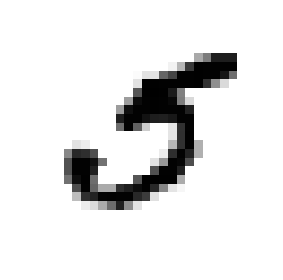

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


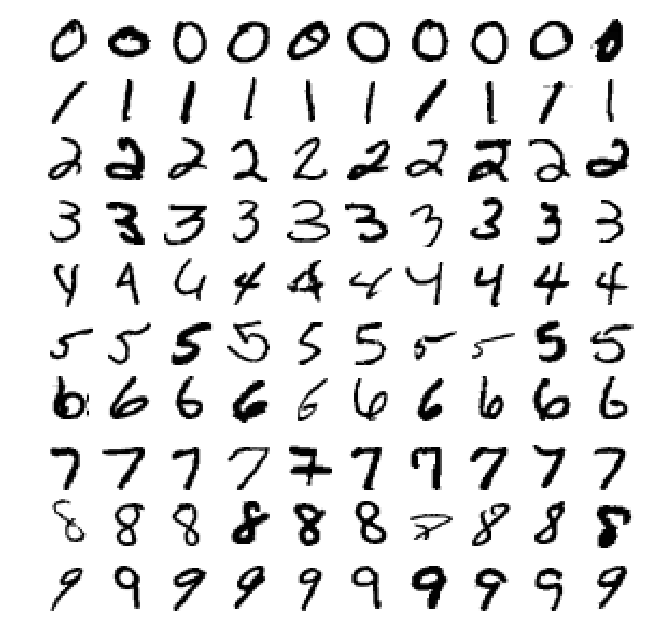

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [9]:
# split training set and testset (60000, 10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
# cross-validation 할때 같은 번호들이 선택되지 않고 골고루 선택되기 위해 shuffling 함 

import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

In [11]:
# 5 이거나 혹은 아니거나로 분류해보기 

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# Stochastic Gradient Descent (SGD) classifier, 
# using Scikit-Learn’s SGDClassifier class. (큰 데이터셋과 online learning 에 적합하다.)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [13]:
# 숫자 5를 알수 있도록 함 predict 
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

## IMPLEMENTING CROSS-VALIDATION
StratifiedKFold : class 의 비율별로 test, train 을 나누고 fold 를 만듬 

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    # test set 을 모델에 넣어 prediction 값을 꺼내고 맞는 비율을 확인
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


## Measuring Accuracy Using Cross-Validation 

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9502 ,  0.96565,  0.96495])

In [21]:
# 5가 아닌 class 들 확인

from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.909  ,  0.90715,  0.9128 ])

이미지의 10% 만이 5이기 때문에 모델의 정확도가 90%가 나왔다. 
비 대칭 데이터 세트 

## Confusion Matrix
분류를 구분하기에 좋은 방법으로
A 로 분류 해야 하는것을 B 로 했는지 알수 있다.

In [22]:
# 예측 값을 구함
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
# 예측 값과 실제 정답을 넣고 돌림
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

|  |Negative |Positive|
|:--------- |:---------|:---------|
|Negative |실제 5가 아닌데 5가 아닌라고 판단 | 5가 아닌데 5라고 판단|
|Positive|5인데 5가 아니라고 함 | 5인데 5가 아니라고함 |

* 1307, 1077 은 예측을 잘못한 값

실제 값을 넣었을 때 Confusion Matrix

In [24]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* Precision : 예측의 정확성, 긍정적으로 예측한것 중에 진짜 긍정적인인 비율 
>![alt text](3precision.png "precision")

* Recall : 실제 긍정적인 비율중에 정확히 검출된 긍정적인 비율 
>![alt text](3recall.png "recall")

>![alt text](3TNFP.png "recall")

## Precision and Recall

잘 예측한것 

In [25]:
from sklearn.metrics import precision_score, recall_score

print(4344 / (4344 + 1307))
precision_score(y_train_5, y_train_pred)

0.7687135020350381


0.76871350203503808

잘 예측된것

In [26]:
print(4344 / (4344 + 1077))
recall_score(y_train_5, y_train_pred)

0.801328168234643


0.80132816823464303

* F1 Score : Predicsion 과 recall 을 합쳐서 확인함
> ![alt text](3f1score.png "f1 score")

In [27]:
from sklearn.metrics import f1_score
print(4344 / (4344 + (1077 + 1307)/2))
f1_score(y_train_5, y_train_pred)

0.7846820809248555


0.78468208092485547

precision 과 recall 중 더 중요하게 생각 해야 되는 부분이 다르다.

어린아이에게 비디오를 보여주는 경우 안전한 것만 보여주도록 _precision_ 을 중요하게 생각하고 <br>
도둑을 잡기위해서는 잘못된 곳에 경고가 울려 경비가 출동하더라도 모든 도둑을 잡을 수 있도록 _recall_ 을 중요하게 생각 해야 한다. 

## Precision/Recall Tradeoff

이전에 생성한 SGD Classifier 의 결과를 이용 (Stochastic gradient descent) <br>
predict() -> decision function 을 기반으로 점수가 계산되고 <br>
점수가 임계치 보다 크면 긍정 클래스를 할당하고 그렇지 않으면 부정 클래스를 할당
> ![alt text](3Tradeoff.png "tradeoff")

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 161855.74572176])

In [29]:
#SGD 기본 임계치는 0 으로 잡혀 있음 
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [30]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [31]:
# 모든 인스턴스점수 예측 대신 결정 스코어 리턴 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


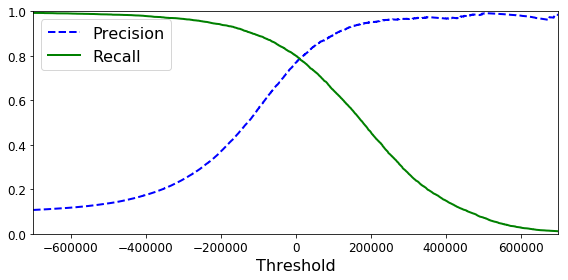

In [33]:
# 모든 임계치의 precision, recall 보기 
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [34]:
(y_train_pred == (y_scores > 0)).all()

True

In [35]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.86592051164915484

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172

Saving figure precision_vs_recall_plot


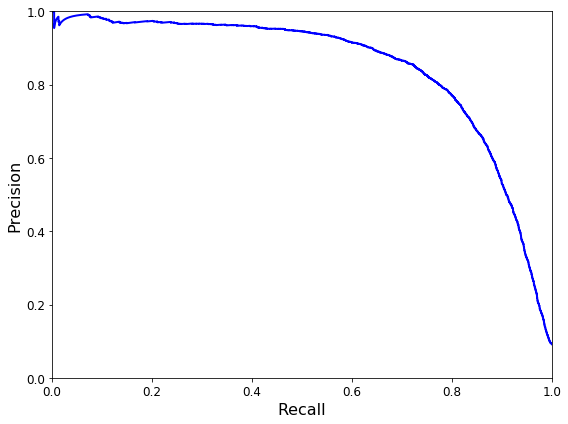

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves (receiver operating characteristic)
binary classifiers <br>
true positive rate (TP rate) against false positive rate (FP rate)

In [38]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


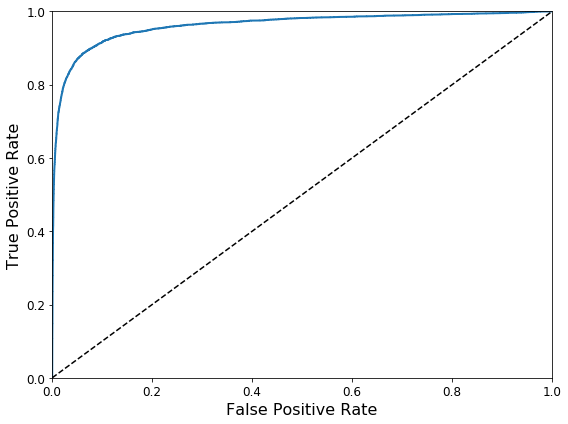

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

* AUC : area under the curve (아래 면적 측정)

random classifier 의 AUC 는 0.5 이다. 

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.96244965559671547

* RandomForestClassifier

predict_proba() 함수 사용 return array (각 인스턴스가 클래스에 속할 확률 포함)

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [42]:
y_probas_forest

array([[ 1. ,  0. ],
       [ 0.9,  0.1],
       [ 1. ,  0. ],
       ..., 
       [ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 1. ,  0. ]])

In [43]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


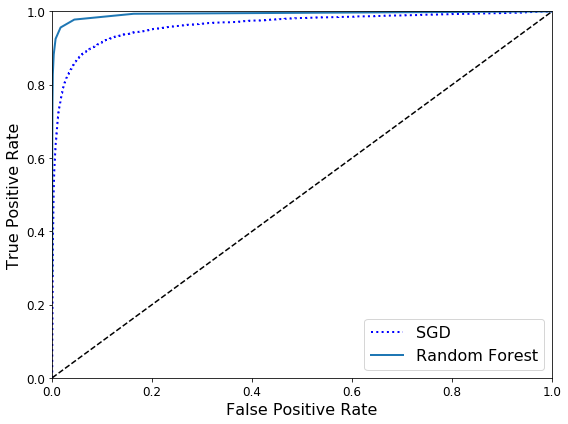

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.99312433660038291

In [46]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.98529734474434938

In [47]:
recall_score(y_train_5, y_train_pred_forest)

0.82826046854823832

# Multiclass Classification
3개 이상의 클래스를 구분 할때 사용<br>
Random Forest classifiers or naive Bayes classifiers <br>
(Support Vector Machine classifiers or Linear classifiers 는 binary classifiers)

* OvA (one-versus-all) : when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score.

* OvO (one-versus-one) : to train a binary classifier for every pair of digits
    두가지 클래스에 대해서만 학습하면 된다.
    
Support Vector Machine classifiers 과 같은 알고리즘은 train set 의 scale 에 약하다. 이럴때에 OvO 를 사용하면 더 빠르고 many classifiers on small training sets 에 좋다. 

대부분은 OvA 를 사용 

In [48]:
# SGDClassifier: 
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [49]:
# decision_function 자동으로 OvA 를 호출 함 
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [50]:
np.argmax(some_digit_scores)

5

In [51]:
# classes 에 저장된 값을 확인해 봐야 한다. 
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [52]:
sgd_clf.classes_[5]

5.0

* OneVsOneClassifier or OneVsRestClassifier classes 사용

In [53]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [54]:
len(ovo_clf.estimators_)
# 0,1,2,3..10 까지 0,1/ 0,2/ 0,3 ....

45

In [55]:
# RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [56]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [57]:
# SGD 분류 측정 
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84063187,  0.84899245,  0.86652998])

In [58]:
# scaling 을 통해서 모델을 더 좋게 분류 시킬 수 있다. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91011798,  0.90874544,  0.906636  ])

# Error Analysis
* checklist: 
    - exploring data preparation options
    - trying out multiple models shortlisting the best ones 
    - fine-tuning their hyperparameters using GridSearchCV

데이터에 맞는 모델을 찾았다는 가정하에 모델을 튜닝 할수 있는 방법으로 오류를 분석하는 것이다.

* confusion matrix 사용 <br>
cross_val_predict() 대신에 the confusion_matrix() function 사용

In [59]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]])

In [60]:
# 그래프로 확인하기 matshow()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


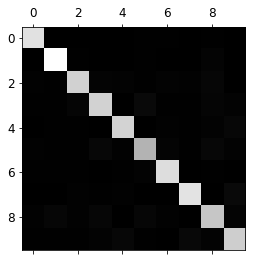

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

사선은 정확하게 분류된 것들 <br>
숫자보다 비율을 보기에 좋다 (작아서 안보이지만...)<br>
숫자 5에 대해서 잘 분류 하지 못하였다. (다른것보다 좀더 검다) - 샘플이미지가 적을수 있다. 

에러에 중점을 맞춰서<br>
해당 클래스들을 이미지 수에 맞춰서 나누면 오류율을 비교 할 수 있다. (샘플 수에 따라 변할수 있는 것을 방지)

In [62]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


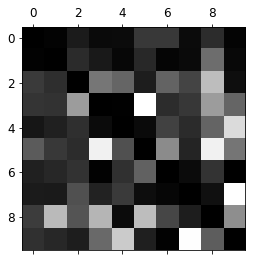

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

행은 acture class <br>
열은 predicted class <br>
8과 9를 다른 숫자로 해깔려 하는 경우가 많다 

* 3/5 confusion 의 경우를 살펴보자 (개별로 보기 : 어렵고 시간이 많이 걸림)

Saving figure error_analysis_digits_plot


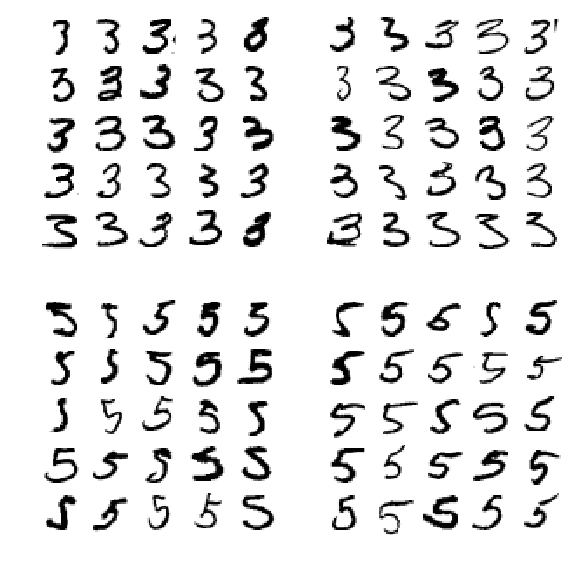

In [64]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

3인데 5로 분류 [0,1], 5인데 3으로 분류 [1,0] 은 잘못 구분한 것들 <br>
SGD classifier 는 리니어 모델로 각각의 픽셀마다 weight 를 줘서 새로운 이미지를 볼떄 마다 픽셀의 weight 는 더해진다. <br>
3 과 5는 몇 픽셀 차이 나지 않는다. 중점이 다른거나 돌아가는 경우 구분하기 힘들다. 

# Multilabel classification
사진에 누구누구 있는지 구분<br>
[0, 1, 1] 엘리스, 밥, 셀리 중에 있는 사람을 구분한다. 

KNeighborsClassifier 를 이용하여 7보다 크거나 같은지 그리고 홀수인지 구분 <br>
y_multilabel 두개의 타갯 라벨

In [65]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [66]:
# 5를 넣어서 맞는지 확인 
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [ ]:
# 간단히 f1 점수를 내어 평균 스코어를 얻을 수 있다. 
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

 average="macro" 를 weight 로 설정하면 각 클래스에 같은 가중치를 부여 할 수 있다. 

# Multioutput classification
여러개를 입력해서 여러개로 출력

여러 픽셀로 이뤄진 이미지를 입력으로 넣고 noise 를 제거한 이미지를 출력함 


In [67]:
# 노이즈 추가한 이미지 만들기 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


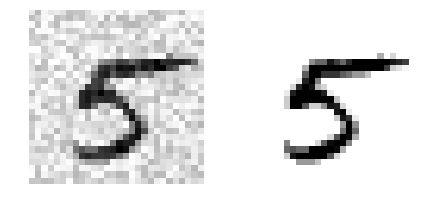

In [68]:
# 노이즈 이미지와 그냥 이미지 그리기
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

Saving figure cleaned_digit_example_plot


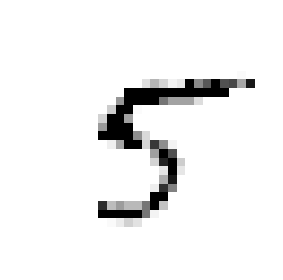

In [69]:
# KNeighborsClassifier 를 이용해 트레인 시킴 
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")